# 1 - Introduction

```
Name      : Muhamad Arif Rachman Hatab

Batch     : FTDS-017-RMT

Dataset   : A collection of scrapped tweets annotated with indentified emotions.

Objective : Implementing Neural Network to Predict People Emotions Based on Tweets.
```

Link to [data](https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text?select=tweet_emotions.csv).

# 2 - Import Libraries

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
from google.colab import drive

import re # Preprocessing
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
nltk.download('stopwords') # Dwonload Text Preprocessing
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import seaborn as sns # Visualization
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

import tensorflow as tf # Modelling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import TextVectorization, Dropout, Embedding, Dense, LSTM, Bidirectional, GlobalAveragePooling1D

import json # Saving
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# 3 - Data Loading

In [ ]:
# Mounting Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unzip Downloaded File
!unzip -q /content/gdrive/MyDrive/kaggle/tweet_emotions.csv.zip

In [ ]:
# Load Dataset
path = '/content/tweet_emotions.csv'
pd.set_option('display.max_columns', None)
df = pd.read_csv(path)
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
# Chechking Dataset Shape
print(df.shape)

(40000, 3)


To make it not bias we will change column `sentiment` into `emotion`, then reorder columns `tweet_id`, `content` and `emotion` to make the corpus look more tidy.

In [ ]:
# Renaming
df = df.rename(columns={'sentiment' : 'emotion'})

# Tidying Up Columns Order
df = df[['tweet_id', 'content', 'emotion']]
df.head()

,tweet_id,content,emotion
0,1956967341,@tiffanylue i know i was listenin to bad habi...,empty
1,1956967666,Layin n bed with a headache ughhhh...waitin o...,sadness
2,1956967696,Funeral ceremony...gloomy friday...,sadness
3,1956967789,wants to hang out with friends SOON!,enthusiasm
4,1956968416,@dannycastillo We want to trade with someone w...,neutral


# 4 - Exploratory Data Analysis

## 4.1 - Labels Distribution

In [ ]:
# Check Target Distribution
target_count = df.groupby(['emotion'], as_index=False)['content'].count()
target_count = target_count.rename(columns={'content' : 'count'})
target_count

,emotion,count
0,anger,110
1,boredom,179
2,empty,827
3,enthusiasm,759
4,fun,1776
5,happiness,5209
6,hate,1323
7,love,3842
8,neutral,8638
9,relief,1526


In [ ]:
# Target Label
target = list(target_count['emotion'].unique())
target

['anger',
 'boredom',
 'empty',
 'enthusiasm',
 'fun',
 'happiness',
 'hate',
 'love',
 'neutral',
 'relief',
 'sadness',
 'surprise',
 'worry']

Target consist of 13 different labels, which are 'anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', sadness', 'surprise', and 'worry'.

In [ ]:
# Function to Show Bar Values
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

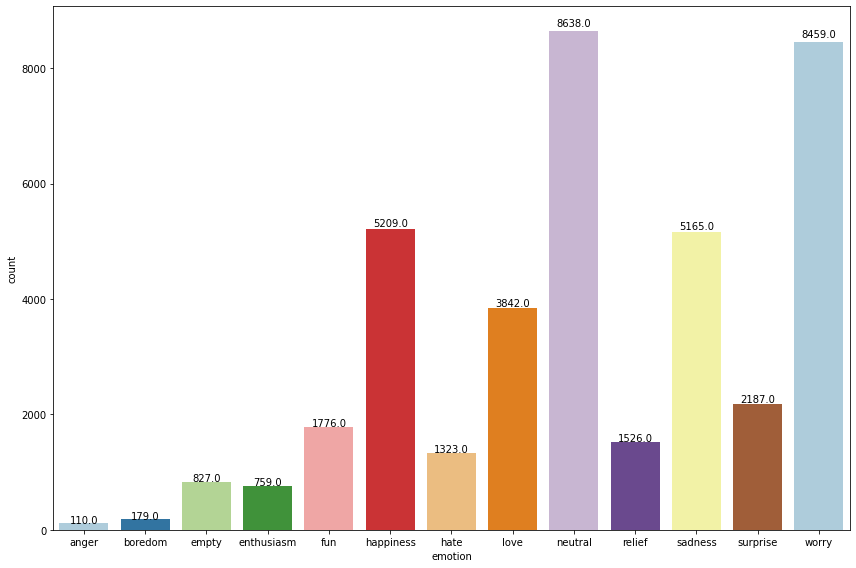

In [ ]:
# Set Color Palette
color = sns.color_palette('Paired', len(target_count))

# Visualize Target Distribution
plt.figure(figsize=(12,8))
ax = sns.barplot(data=target_count, x='emotion', y='count', palette=color)
show_values(ax)
plt.tight_layout()
plt.show()

Target labels are heavily imbalanced, above we see that the overall data dominated with content with `neutral` (8638) and `worry` (8459) emotions, while on the other hand target that are minority are `anger` (110) and `boredom` (179).

From writer experience, using all label will only cause the model performance to be really poor, the last time the writer training the model with all labels included we have the result as follow:
```
1. loss         : .11
2. accuracy     : .96
3. val_loss     : 7.23
4. val_accuracy : 0.23
```
Although the performance in train set is really good, but we could see that the loss/error in validation has exceeding 100% marks.

To undersampling the stand out labels is preferably not the best solution to be applied with unstructructured data like this.

The countermeasure that fit for this kind of problem is to utilize labels that are frequently appeared in the corpus, by that the selected labels that will be included in this next cycle would be:
```
1. happiness
2. love
3. neutral
4. sadness
5. worry
```
The handling for this problem was done in section 5.3.

## 4.2 - Checking Missing Values and Duplicated Values

In [ ]:
# Check For Missing Values
df.isna().sum()

tweet_id    0
content     0
emotion     0
dtype: int64

In [ ]:
# Check For Duplicated Content
print('Duplicated content in the dataset : ',df.duplicated().sum())
print('Duplicated values in "content"    : ',df['content'].duplicated().sum())

Duplicated content in the dataset :  0
Duplicated values in "content"    :  173


No missing values and no duplicated data from the dataset, but there are 173 tweets with same or similar contents.

## 4.3 - Stopwords Distribution

In [ ]:
# Check The Amount of Stopwords in The Dataset
stop_words = set(stopwords.words("english"))

temp =df.copy()
temp['stop_words'] = temp['content'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.head()

,tweet_id,content,emotion,stop_words
0,1956967341,@tiffanylue i know i was listenin to bad habi...,empty,6
1,1956967666,Layin n bed with a headache ughhhh...waitin o...,sadness,4
2,1956967696,Funeral ceremony...gloomy friday...,sadness,0
3,1956967789,wants to hang out with friends SOON!,enthusiasm,3
4,1956968416,@dannycastillo We want to trade with someone w...,neutral,6


In [ ]:
print('Total stopwords in dataset :', temp.stop_words.sum())
temp.stop_words.value_counts()

Total stopwords in dataset : 161987


2     5477
3     5405
4     4923
1     4657
5     4264
6     3676
0     3647
7     2775
8     2057
9     1395
10     914
11     420
12     230
13     119
14      31
15       6
17       2
16       2
Name: stop_words, dtype: int64

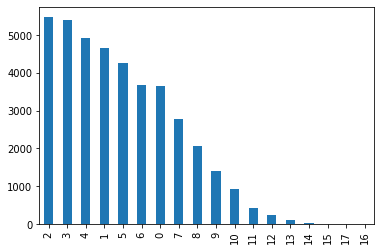

In [ ]:
# Visualize
temp.stop_words.value_counts().plot(kind='bar')

There are 17 types of stopwords with a total of stopwords over 161,000 words present in the dataset.

Stopwords have little contribution in defining emotion from tweets, hence need to be excluded. The handling will be done in section 5.2.

# 5 - Data Preprocessing

## 5.1 - Handling Duplicated Values

In [ ]:
# Check Rows in Content with Duplicated Values
df[df['content'].duplicated() == True]

,tweet_id,content,emotion
366,1957048870,I feel so deflated. No more doggy.,worry
521,1957088574,Somebody please save the polar bears!,worry
1026,1957198430,I'm at work,neutral
3684,1958103183,@dublins98dave me too! I am down 400 euro,sadness
4363,1960336689,"is upset, I left my phone at home again",worry
...,...,...,...
39859,1753886681,Happy Mothers Day,love
39898,1753902524,happy mothers day!,love
39913,1753902827,happy mother's day!,happiness
39915,1753903008,happy mother's day everyone,love


In [ ]:
# Checking Specific Content
df[df['content'] == df.iloc[4363]['content']]

,tweet_id,content,emotion
4339,1960327601,"is upset, I left my phone at home again",sadness
4363,1960336689,"is upset, I left my phone at home again",worry


These particular tweets is similar to each other though both tweets have different category of emotion.

In [ ]:
df[df['content'] == df.iloc[37327]['content']]

,tweet_id,content,emotion
30563,1751642665,Happy Mother's Day!,happiness
31699,1752022187,Happy Mother's Day!,happiness
31931,1752123611,Happy Mother's Day!,love
32399,1752287998,Happy Mother's Day!,surprise
35295,1753073780,Happy Mother's Day!,love
36286,1753275323,Happy Mother's Day!,love
37159,1753435395,Happy Mother's Day!,neutral
37305,1753466795,Happy Mother's Day!,love
37327,1753467668,Happy Mother's Day!,love
38806,1753713523,Happy Mother's Day!,love


In [ ]:
df[df['content'] == df.iloc[34593]['content']]

,tweet_id,content,emotion
30930,1751783597,happy mother's day,happiness
33457,1752618186,happy mother's day,love
34060,1752774067,happy mother's day,love
34593,1752917637,happy mother's day,happiness
35875,1753197260,happy mother's day,neutral
37312,1753467002,happy mother's day,love
37483,1753498511,happy mother's day,love
38311,1753633337,happy mother's day,love


We see that above tweets are having the same content, with varying type of emotion between happiness, surprise, love and neutral.

In [ ]:
df[df['content'] == df.iloc[33359]['content']]

,tweet_id,content,emotion
33353,1752590956,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,happiness
33359,1752591163,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,neutral
33365,1752591361,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,enthusiasm
33370,1752591575,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,neutral
33376,1752591756,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,happiness
33383,1752591969,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,fun
33388,1752592151,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,love
33396,1752592317,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,neutral
33401,1752592527,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,relief
33404,1752592765,FREE UNLIMITED RINGTONES!!! - http://tinyurl.c...,empty


Tweets above is more likely to be spam tweets rather than normal, day-to-day tweets.

Overall, tweets above seem to be having varying emotions despite their exact same content, for most of the tweet. Hence we will drop/remove this duplicated content, since keeping them would only make the model more biased.

Since we have over 40,000 gathered tweets, dropping duplicated `content` means we only excluded around 0.4% data, and in writer personal opinion, this is still considered acceptable, and will not distort the end results.

In [ ]:
# Removing Duplicated Contents
dup_index = df[df['content'].duplicated() == True].index
df.drop(dup_index, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
# Show shape
df.shape

(39827, 3)

We have trim duplicated values in `content` and reduced the dataset into 39,827 rows.

## 5.2 - Text Preprocessing

In [ ]:
# Define Lemmetizer and List of Stopwords
lemmetizer = WordNetLemmatizer()
stpwrd = list(set(stopwords.words('english')))
#stpwrd.append('')

Below are needed process to simplify documnets in the corpus.

In writer personal opinion, transforming the corpus to lower case should be avoided since some words with different case sentence could interprete different emotions.

Lemmetizer utilized to make sure that we really transform words into its base form, because compared to stemmer, for some cases it can not simplify words into its base form,for example if we were to transform the word 'simplified', using stemmer it will transform the word to 'simplifi' which is not in its correct form.


In [ ]:
# Function for Text Preprocessing
def init_process(text):
  # Remove Mentions
  text = re.sub("@[A-Za-z0-9_]+", " ", text)
  
  # Remove Hashtags
  text = re.sub("#[A-Za-z0-9_]+", " ", text)
  
  # Remove Enter/Space
  text = re.sub(r"\\n", " ",text)
  
  # Remove Whitespace
  text = text.strip()

  # Remove Link
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Remove Characters That Are Not String
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Remove RT
  text = re.sub("rt", " ",text)

  # Tokenizing
  tokens = word_tokenize(text)

  # Remove Stopwords
  text = ' '.join([word for word in tokens if word not in stpwrd])
  
  # Lemmetizing
  text = lemmetizer.lemmatize(text)
  
  return text

Function below utilized to rid off words that consist only of 2 letters or less, in which, writer see in section 5.5 have little to nein meaning.

Example for targeted words are as follows:
* nt
* u
* im
* ect

There is also a content that have no words which writer found when exploring the cleaned corpus previously.

In [ ]:
# Applying Text Preprocessing
df['processed_content'] = df['content'].apply(lambda x: init_process(x))

# Remove Words with Less Than 2 Letters
shortword = re.compile(r'\W*\b\w{1,3}\b')
df.processed_content=df.processed_content.apply(lambda x: shortword.sub('', x) )
df.head()

,tweet_id,content,emotion,processed_content
0,1956967341,@tiffanylue i know i was listenin to bad habi...,empty,know listenin habit earlier freakin
1,1956967666,Layin n bed with a headache ughhhh...waitin o...,sadness,Layin headache ughhhh waitin call
2,1956967696,Funeral ceremony...gloomy friday...,sadness,Funeral ceremony gloomy friday
3,1956967789,wants to hang out with friends SOON!,enthusiasm,wants hang friends SOON
4,1956968416,@dannycastillo We want to trade with someone w...,neutral,want trade someone Houston tickets


## 5.3 - Handling Imbalanced Value

In [ ]:
# Filter Corpus Based on Selected Labels
df = df[df['emotion'].isin(['happiness', 'love', 'neutral', 'sadness', 'worry'])].reset_index(drop=True)

# Show Results
df['emotion'].value_counts()

neutral      8598
worry        8437
happiness    5184
sadness      5154
love         3785
Name: emotion, dtype: int64

Distribution between minority labels and majority labels above are having ratio above 1:2, to avoid underfitting, we will try to undersample the corpus.

In [ ]:
# Define Undersample Strategy
undersample = RandomUnderSampler(sampling_strategy='not minority', random_state=11)

In [ ]:
# Split x and y
x = df[['content', 'processed_content']]
y = df['emotion']

In [ ]:
# Undersampling 1st Majority class
x, y = undersample.fit_resample(x, y)

In [ ]:
df_us = pd.concat([x, y], axis=1)
df_us['emotion'].value_counts()

happiness    3785
love         3785
neutral      3785
sadness      3785
worry        3785
Name: emotion, dtype: int64

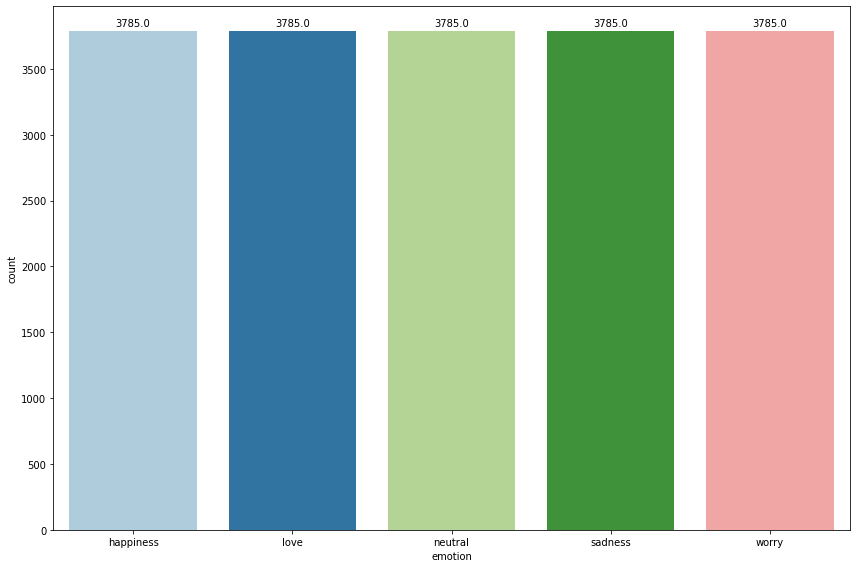

In [ ]:
# Visualize Target Distribution
plt.figure(figsize=(12,8))
ax = sns.countplot(data=df_us, x='emotion', palette=color)
show_values(ax)
plt.tight_layout()
plt.show()

After handling imbalance value, we see that the distribution of each label are all at the same value count.

## 5.4 - Convert Target

In [ ]:
# Split Corpus
x_train_val, x_test, y_train_val, y_test = train_test_split(df_us.processed_content, 
                                                    df_us.emotion, 
                                                    test_size=0.25, 
                                                    random_state=11, 
                                                    stratify=df_us.emotion)

# Split Train and Validation
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=11)


print('x_train size : ', x_train.shape)
print('y_train size : ', y_train.shape)
print('x_val size   : ', x_val.shape)
print('y_val size   : ', y_val.shape)
print('x_test size  : ', x_test.shape)
print('y_test size  : ', y_test.shape)

x_train size :  (10644,)
y_train size :  (10644,)
x_val size   :  (3549,)
y_val size   :  (3549,)
x_test size  :  (4732,)
y_test size  :  (4732,)


In [ ]:
# Define Encoder
encoder = LabelEncoder()

# Convert Target to Numerical
y_train_le = encoder.fit_transform(y_train)
y_val_le   = encoder.transform(y_val)
y_test_le  = encoder.transform(y_test)
y_train_le

array([1, 1, 0, ..., 3, 4, 3])

## 5.5 - EDA (Cleaned Data)

### Words Distribution Per Emotion

In [ ]:
# Make a Copy for EDA Purposes
data = df_us.copy()

In [ ]:
# Count Words
data['no_of_words'] = data['processed_content'].apply(lambda x: len(nltk.word_tokenize(x)))

# Show Head
data.head()

,content,processed_content,emotion,no_of_words
0,is going back home love ya Zagrebe &lt;3,going back home love Zagrebe,happiness,5
1,@Lizzs_Lockeroom Maybe But you start to real...,Maybe really like team living years city Cups ...,happiness,9
2,just saw UP it was a cute movie (:passed by a...,cute movie passed place called peasants kitch...,happiness,9
3,I've just realised - 400 FOLLOWERS! YAY! xx,realised FOLLOWERS,happiness,2
4,headed to the beach with puppy maverick hugs a...,headed beach puppy maverick hugs much aloha,happiness,7


We will see the distribution of words in the corpus after preprocessing.

In [ ]:
# Describe Count Results
data[['no_of_words']].describe()

,no_of_words
count,18925.000000
mean,5.614003
std,3.198972
min,0.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,17.000000


There are 31,158 words total inside the preprocessed corpus, with maximum and minimum count of words in the document are at 17 words and 0 word respectively.

0 in this case means whitespace 

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

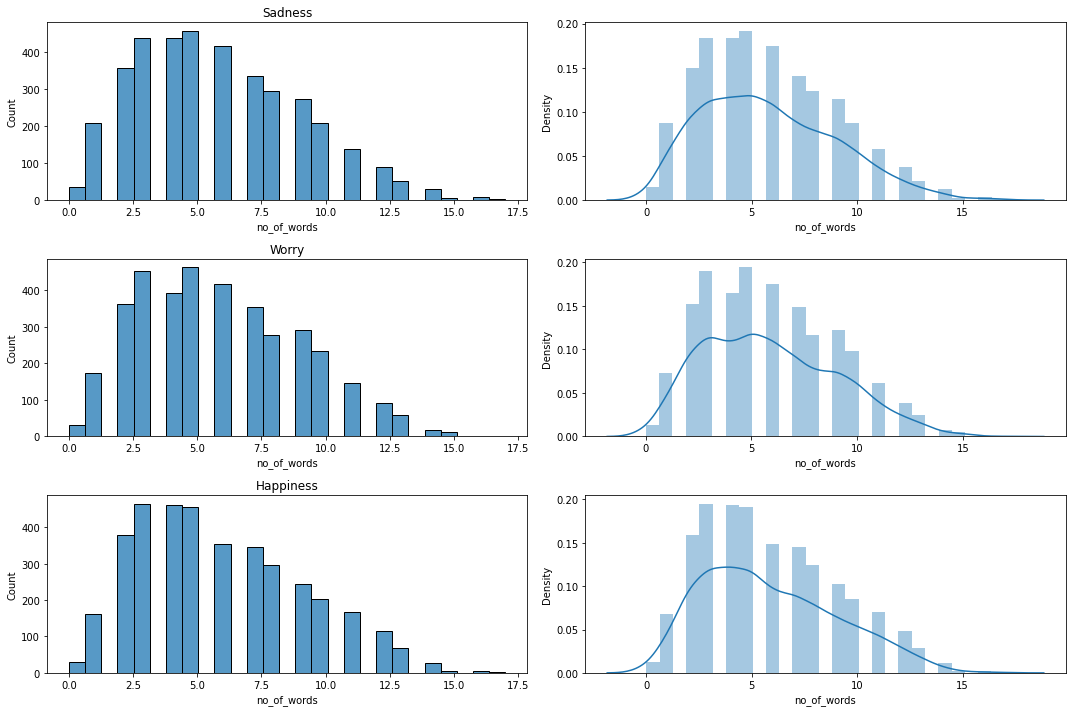

In [ ]:
# Plot Word Counts Per Selected Emotion
plt.figure(figsize=(15,10))

plt.subplot(321) # Sadness
sns.histplot(data[data['emotion'] == 'sadness']['no_of_words'])
plt.title('Sadness')
plt.subplot(322)
sns.distplot(data[data['emotion'] == 'sadness']['no_of_words'])

plt.subplot(323) # Worry
sns.histplot(data[data['emotion'] == 'worry']['no_of_words'])
plt.title('Worry')
plt.subplot(324)
sns.distplot(data[data['emotion'] == 'worry']['no_of_words'])


plt.subplot(325) # Happiness
sns.histplot(data[data['emotion'] == 'happiness']['no_of_words'])
plt.title('Happiness')
plt.subplot(326)
sns.distplot(data[data['emotion'] == 'happiness']['no_of_words'])

plt.tight_layout()
plt.show()

After preprocessing we have reduced the type of words in the corpus into 17 words.

Above we see that for overall corpus, maximum time for 1 word appearing that represented as sadness, worry and happiness are above 400 times.

### Wordcloud

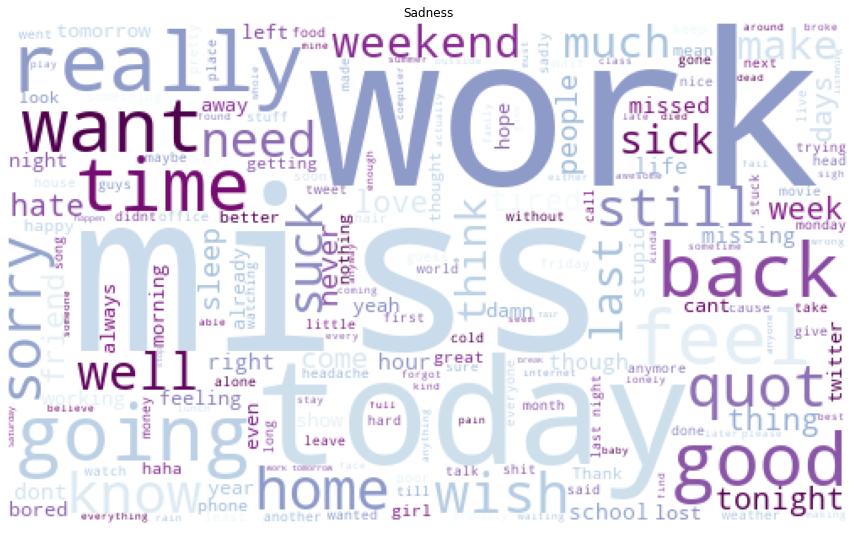

In [ ]:
# Generate Word Clod
w_cloud1 = WordCloud(width = 500, height= 300, random_state= 8, background_color= 'white', colormap='BuPu')
cl_sadness = w_cloud1.generate(data[data['emotion']== 'sadness']['processed_content'].str.cat(sep = ' '))

# Visualize Sadness Words
plt.figure(figsize=(12,8))
plt.title('Sadness')
plt.imshow(cl_sadness)
plt.axis('off')
plt.tight_layout()
plt.show()

words that interpreted as representative of sad emotion are mainly correlated with daily responsibility, feeling of lingging or homesickness, and guilty feeling.

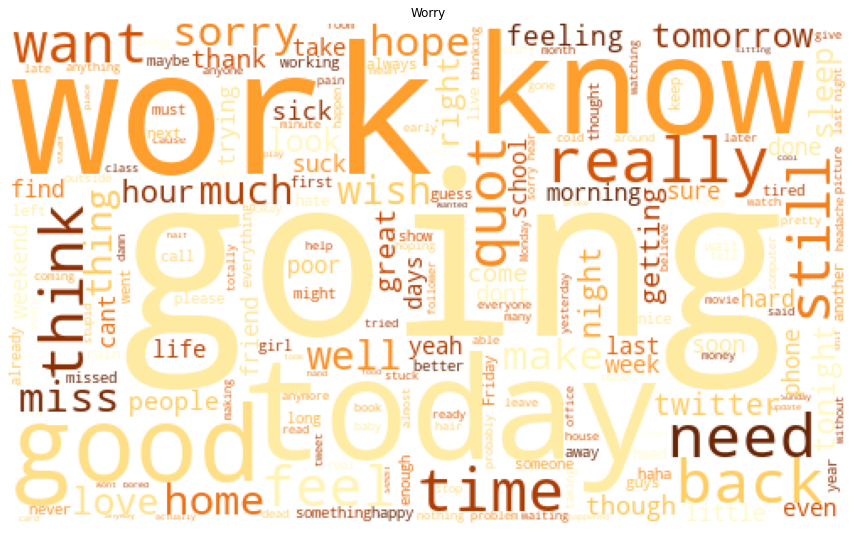

In [ ]:
# Generate Word Clod
w_cloud2 = WordCloud(width = 500, height= 300, random_state= 8, background_color= 'white', colormap='YlOrBr')
cl_worry = w_cloud2.generate(data[data['emotion']== 'worry']['processed_content'].str.cat(sep = ' '))

# Visualize Worry Words 
plt.figure(figsize=(12,10))
plt.title('Worry')
plt.imshow(cl_worry)
plt.axis('off')
plt.tight_layout()
plt.show()

Words that interpreted as emotion worry are almost the same with sadness, but we could see that for emotion worry, most words that frequently appearing are really leaning to daily responsibilities and its correlation to time, then about one's understanding towards something.

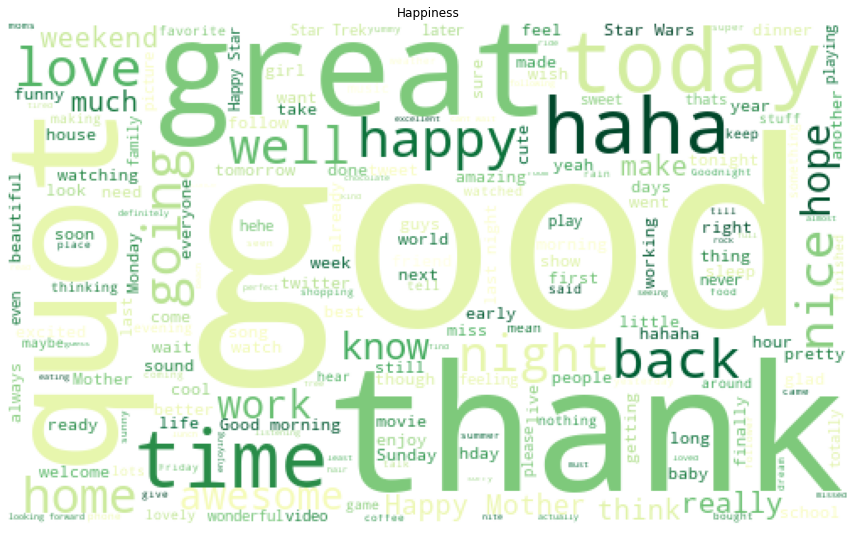

In [ ]:
# Generate Word Clod
w_cloud3 = WordCloud(width = 500, height= 300, random_state= 8, background_color= 'white', colormap='YlGn')
cl_happiness = w_cloud3.generate(data[data['emotion']== 'happiness']['processed_content'].str.cat(sep = ' '))

# Visualize Happiness Words 
plt.figure(figsize=(12,10))
plt.title('Happiness')
plt.imshow(cl_happiness)
plt.axis('off')
plt.tight_layout()
plt.show()

above we see that most words for happy emotion are words that are representing ones gratefulness, laugh words, and words if something that could entertain them.

## 5.6 - Tokenization & Embedding

In [ ]:
# Get Vocabularies
vectorizer = TfidfVectorizer()

x_train_vec = vectorizer.fit_transform(x_train)
x_val_vec   = vectorizer.transform(x_val)
x_test_vec  = vectorizer.transform(x_test)

# Show Vectorized Corpus
x_train_vec

<10644x11419 sparse matrix of type '<class 'numpy.float64'>'
	with 58049 stored elements in Compressed Sparse Row format>

In [ ]:
# Find Amount of Vocabularies and Length of Token
vocab   = len(vectorizer.vocabulary_.keys())
max_len = max([len(i.split(" ")) for i in x_train])

# Visualize
print('Amount of vocabularies present in corpus : ', vocab, 'words')
print('Maximum length of sentence in corpus :', max_len, 'words')

Amount of vocabularies present in corpus :  11419 words
Maximum length of sentence in corpus : 18 words


In [ ]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=vocab,
                                       standardize='strip_punctuation',
                                       split='whitespace',
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_len,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(x_train)

For vectorization, since we want to keep case sentence as is, we standardize only by strip_punctuation.

ngrams set to default which is 1, max_tokens set to 15,546 (amount of token in corpus) while output_sentence_length set to maximum length of sentence present in corpus, which is 18 words.

Above are list of tokens that are sorted on each token frequencies of appearing in overall corpus.

From writer first run on this project, there are many words that composed by only 2 or less letters, in which some of those have a little to no meaning, hence on the next run/cross check, writer add a small function in chapter 5.2 to remove words that only consist 2 letters or less, to make the corpus less bias in the 'eye' of the model.

In [ ]:
# Embedding
embedding = Embedding(input_dim=vocab,
                      output_dim=200,
                      embeddings_initializer="uniform",
                      input_length=max_len
                      )

In [ ]:
  # Document
  print('Preprocessed document : ')
  print(df.processed_content[0])
  print('')

  ## Text Vectorization Result
  print('Text vectorization result :')
  print(text_vectorization([df.processed_content[0]]))
  print('\nUkuran vector : ', text_vectorization([df.processed_content[0]]).shape)
  print('')

  ## Embedding Result
  print('Embedding result :')
  print(embedding(text_vectorization([df.processed_content[0]])))
  print('\Vector size : ', embedding(text_vectorization([df.processed_content[0]])).shape)

Preprocessed document : 
Layin headache ughhhh waitin call

Text vectorization result :
tf.Tensor(
[[   1  332 2300 2287  143    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(1, 18), dtype=int64)

Ukuran vector :  (1, 18)

Embedding result :
tf.Tensor(
[[[-0.04354244 -0.04810297  0.02472157 ... -0.00638191  0.02840998
   -0.02328656]
  [ 0.02950479  0.04465009  0.02735278 ...  0.03185649 -0.02205401
   -0.03999287]
  [-0.01592731  0.04060761  0.00610211 ...  0.03127687 -0.02410435
    0.0077178 ]
  ...
  [-0.01052966  0.01937672 -0.01362874 ... -0.02684256  0.03988569
   -0.00570855]
  [-0.01052966  0.01937672 -0.01362874 ... -0.02684256  0.03988569
   -0.00570855]
  [-0.01052966  0.01937672 -0.01362874 ... -0.02684256  0.03988569
   -0.00570855]]], shape=(1, 18, 200), dtype=float32)
\Vector size :  (1, 18, 200)


On text vectorization we see that the document is converted into 20 integer that represent maximum length of sentences, on the otherhand each elemnt number represents how often the specific word appear in the corpus.

Embedding turns the vectorized document into vectors of scaled integers, inwhich the integer represent each word frequencies of appearing in corpus.

# 6 - Scenario 1

## 6.1 - Model Definition

In [ ]:
# Prepping Target with Keras Utility
y_train_cat = to_categorical(y_train_le)
y_val_cat   = to_categorical(y_val_le)
y_test_cat  = to_categorical(y_test_le)

y_train_cat.shape # Check Target Dimension

(10644, 5)

Defining baseline model:

In [ ]:
# Model Definition with Fully Connected Layer
model0 = Sequential()
model0.add(text_vectorization)
model0.add(embedding)
model0.add(GlobalAveragePooling1D())
model0.add(Dense(30,activation='relu'))
model0.add(Dense(30,activation='relu'))
model0.add(Dense(30,activation='relu'))
model0.add(Dense(10,activation='relu'))
model0.add(Dense(5,activation='relu'))
model0.add(Dense(5,activation='softmax'))

model0.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model0.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 18, 200)           2283800   
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 30)                6030      
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                9

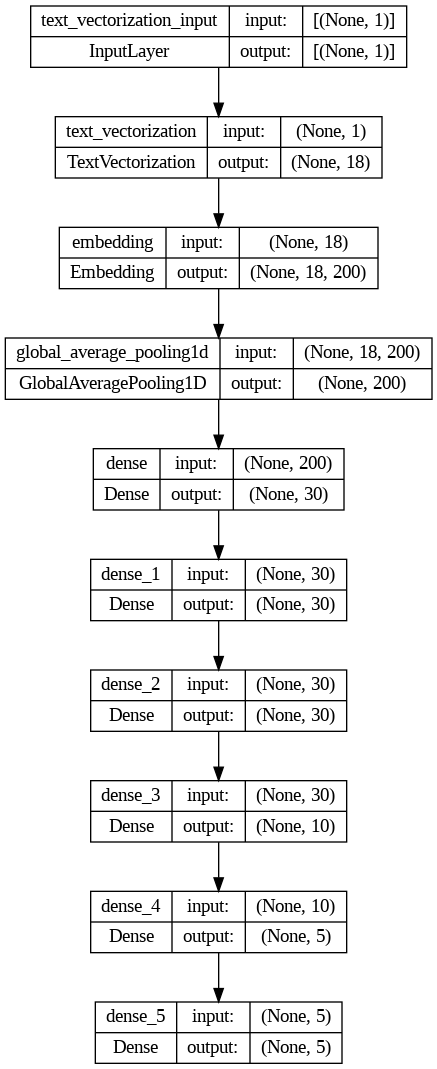

In [ ]:
# Plot Model 1 Architecture
tf.keras.utils.plot_model(model0, show_shapes=True)

Baseline model set as plain as it could be to clearly see the difference between utilizing lstm and not.

## 6.2 - Model Training & Evaluation

In [ ]:
# Model Training with LSTM
model0_hist = model0.fit(x_train,
                         y_train_cat,
                         epochs=30,
                         validation_data=(x_val, y_val_cat))

Epoch 1/30
333/333 [==============================] - 25s 57ms/step - loss: 1.6091 - accuracy: 0.2036 - val_loss: 1.6075 - val_accuracy: 0.2054
Epoch 2/30
333/333 [==============================] - 4s 13ms/step - loss: 1.5628 - accuracy: 0.2718 - val_loss: 1.5798 - val_accuracy: 0.2688
Epoch 3/30
333/333 [==============================] - 2s 7ms/step - loss: 1.4129 - accuracy: 0.3766 - val_loss: 1.6503 - val_accuracy: 0.3043
Epoch 4/30
333/333 [==============================] - 3s 8ms/step - loss: 1.2072 - accuracy: 0.5199 - val_loss: 1.6531 - val_accuracy: 0.3705
Epoch 5/30
333/333 [==============================] - 2s 7ms/step - loss: 0.9406 - accuracy: 0.6554 - val_loss: 1.9331 - val_accuracy: 0.3607
Epoch 6/30
333/333 [==============================] - 2s 6ms/step - loss: 0.7289 - accuracy: 0.7345 - val_loss: 2.1588 - val_accuracy: 0.3607
Epoch 7/30
333/333 [==============================] - 3s 9ms/step - loss: 0.5839 - accuracy: 0.7938 - val_loss: 2.4449 - val_accuracy: 0.3542
Epo

In [ ]:
# Dataframe of Training History
model0_hist_df = pd.DataFrame(model0_hist.history)
model0_hist_df

,loss,accuracy,val_loss,val_accuracy
0,1.609097,0.203589,1.607456,0.205410
1,1.562811,0.271796,1.579814,0.268808
2,1.412855,0.376644,1.650293,0.304311
3,1.207188,0.519917,1.653118,0.370527
4,0.940563,0.655393,1.933129,0.360665
5,0.728889,0.734498,2.158798,0.360665
6,0.583906,0.793781,2.444869,0.354184
7,0.489572,0.828636,2.793291,0.354466
8,0.416795,0.852217,3.059512,0.340378
9,0.371861,0.866404,3.223233,0.337560


For training set we see that the model has accuracy of .98 and loss at .13, but we get loss in validation set passing 100% marks, which at 7.56 and accuracy of .32, this could due to incomplete preprocessing from duplicated word, or there are some words that the model interprete as multiple emotions.

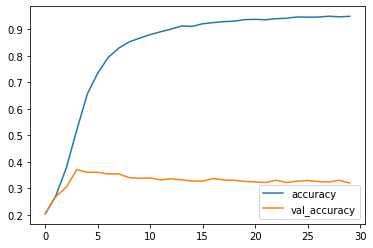

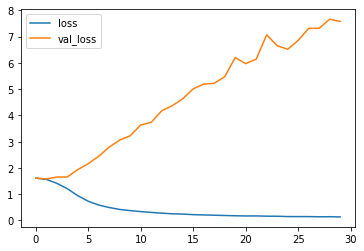

In [ ]:
# Plot Results
model0_hist_df[['accuracy', 'val_accuracy']].plot()
model0_hist_df[['loss', 'val_loss']].plot()

In [ ]:
# Evaluate Test-Set
pred0 = model0.predict(x_test)
y_pred0 = pred0.argmax(axis=1)

print(classification_report(y_test_le, y_pred0))

148/148 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.33      0.29      0.31       946
           1       0.35      0.45      0.39       947
           2       0.30      0.41      0.35       946
           3       0.31      0.31      0.31       947
           4       0.31      0.15      0.20       946

    accuracy                           0.32      4732
   macro avg       0.32      0.32      0.31      4732
weighted avg       0.32      0.32      0.31      4732



The prediction result in test set is as follow:
1. model for scenario 1 prediction accuracy is approximately at .32 for all selected labels
2. the lowest performance was for label 4

# 7 - Scenario 2

## 7.1 - Model Definition

As for improvement, writer utilizing 5 stack of bidirectional layers, with each layer applies forward and backward LSTM. This LSTM was chosen particularly because of : 1.) its performance efficacy is better compared to Gru though is relatively slower; 2.) Can handle the problem of vanishing learned data for basic Recurrent Neural Network.

This could make LSTM able to capture long-term dependencies in sequential data.

In [ ]:
# Model Definition with LSTM
model1 = Sequential()
model1.add(text_vectorization)
model1.add(embedding)
model1.add(Bidirectional(LSTM(150,return_sequences=True)))
model1.add(Bidirectional(LSTM(100, return_sequences=True)))
model1.add(Bidirectional(LSTM(100, return_sequences=True)))
model1.add(Bidirectional(LSTM(50, return_sequences=True)))
model1.add(Bidirectional(LSTM(10)))
model1.add(Dense(5,activation='softmax'))

model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 18, 200)           2283800   
                                                                 
 bidirectional (Bidirectiona  (None, 18, 300)          421200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 18, 200)          320800    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 18, 200)          240800    
 nal)                                                 

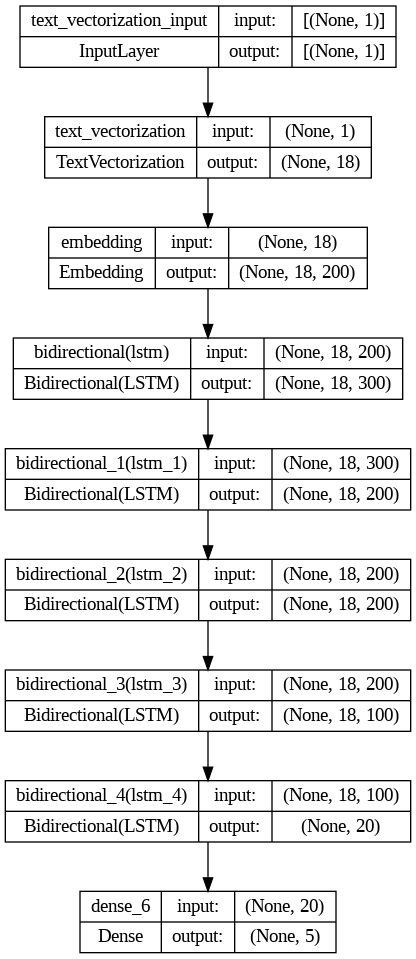

In [ ]:
# Plot Model 1 Architecture
tf.keras.utils.plot_model(model1, show_shapes=True)

Hunderds of neuron deployed for some layers was intended to help improve the model performance in validation and test set, no dropout layer or dropout rate implemented in LSTM because we already see that the validation result is way too underfitted.

## 7.2 - Model Training & Evaluation

In [ ]:
# Model Training with LSTM
model1_hist = model1.fit(x_train,
                         y_train_cat,
                         epochs=30,
                         validation_data=(x_val, y_val_cat))

Epoch 1/30
333/333 [==============================] - 40s 66ms/step - loss: 0.6422 - accuracy: 0.7789 - val_loss: 2.2534 - val_accuracy: 0.3305
Epoch 2/30
333/333 [==============================] - 11s 33ms/step - loss: 0.3779 - accuracy: 0.8657 - val_loss: 2.3221 - val_accuracy: 0.3364
Epoch 3/30
333/333 [==============================] - 8s 25ms/step - loss: 0.3234 - accuracy: 0.8863 - val_loss: 2.7143 - val_accuracy: 0.3297
Epoch 4/30
333/333 [==============================] - 9s 28ms/step - loss: 0.2745 - accuracy: 0.9046 - val_loss: 2.8641 - val_accuracy: 0.3176
Epoch 5/30
333/333 [==============================] - 10s 29ms/step - loss: 0.2472 - accuracy: 0.9103 - val_loss: 3.0807 - val_accuracy: 0.3328
Epoch 6/30
333/333 [==============================] - 9s 26ms/step - loss: 0.2193 - accuracy: 0.9191 - val_loss: 3.2560 - val_accuracy: 0.3243
Epoch 7/30
333/333 [==============================] - 10s 29ms/step - loss: 0.2190 - accuracy: 0.9209 - val_loss: 3.3090 - val_accuracy: 0.

In [ ]:
# Dataframe of Training History
model1_hist_df = pd.DataFrame(model1_hist.history)
model1_hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.642230,0.778937,2.253415,0.330516
1,0.377936,0.865652,2.322107,0.336433
2,0.323385,0.886321,2.714341,0.329670
3,0.274516,0.904641,2.864111,0.317554
4,0.247195,0.910278,3.080741,0.332770
5,0.219295,0.919109,3.256032,0.324317
6,0.218996,0.920894,3.308980,0.332770
7,0.195320,0.929914,3.418119,0.325444
8,0.180114,0.931886,3.514798,0.329670
9,0.185758,0.932262,3.548356,0.323753


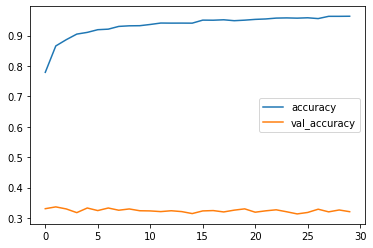

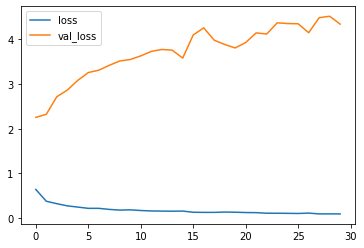

In [ ]:
# Plot Results
model1_hist_df[['accuracy', 'val_accuracy']].plot()
model1_hist_df[['loss', 'val_loss']].plot()

The model performance in training set is improved, with loss dropped to below 10% and accuracy capped at 96%.

Although the performance result in validation set is improved, marked with massive loss drop from 7.56 to 4.34 with accuracy stay at around .3, this result is still not ready to be deployed as business purposes, this is appointed by prediction in test set below.

In [ ]:
# Evaluate Test-Set
pred1 = model1.predict(x_test)
y_pred1 = pred1.argmax(axis=1)

print(classification_report(y_test_le, y_pred1))

148/148 [==============================] - 5s 11ms/step
              precision    recall  f1-score   support

           0       0.33      0.31      0.32       946
           1       0.40      0.43      0.41       947
           2       0.29      0.39      0.33       946
           3       0.32      0.28      0.30       947
           4       0.31      0.23      0.27       946

    accuracy                           0.33      4732
   macro avg       0.33      0.33      0.33      4732
weighted avg       0.33      0.33      0.33      4732



The prediction in test set is overally improved by utilizing BiLSTM, but are still capped at .2 - .43, which is pretty low, and considered as poor performance quality, hence this scenario 2 model is still not ready to be deployed for business purposes.

This phenomenon could probably happen due to incomplete preprocess, highly imbalanced data and ambiguous interpretation of emotion for some words. But in writer personal opinion, this is probably happen because of the latest factor, hence to improved the performance result, a more thorough text preprocessing is needed, as the writer is not that expereienced enough in handling unstructured data, this would obviously a time-consuming process, and cannot be fully excuted.

# 9 - Model Saving

In [ ]:
# Saving Files
with open('encoder.pkl', 'wb') as file_1:      # label encoder for target
  pickle.dump(encoder, file_1)

In [ ]:
# Freeze Model
model1.trainable = False
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 18)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 18, 200)           2283800   
                                                                 
 bidirectional (Bidirectiona  (None, 18, 300)          421200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 18, 200)          320800    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 18, 200)          240800    
 nal)                                                 

# 10 - Model Inferencing

In [ ]:
# Save Model
filepath = "tmp-model"
model1.save(filepath, save_format="tf")

In [ ]:
# Load Model
loaded_model = tf.keras.models.load_model('tmp-model')

In [ ]:
# Make List
twt = ['i want to sleep', 'do you forgive me?', 'i have not sleep for days', 'PLEASE HELP ME LOVE']

# Make Dataframe
tweet = pd.DataFrame()
tweet['content'] = twt
tweet.head()


,content
0,i want to sleep
1,do you forgive me?
2,i have not sleep for days
3,PLEASE HELP ME LOVE


In [ ]:
# Preprocess
tweet['processed_content']= tweet['content'].apply(lambda x: init_process(x))
tweet['processed_content']= tweet['processed_content'].apply(lambda x: shortword.sub('', x))
tweet.head()

,content,processed_content
0,i want to sleep,want sleep
1,do you forgive me?,forgive
2,i have not sleep for days,sleep days
3,PLEASE HELP ME LOVE,PLEASE HELP LOVE


In [ ]:
# Predict
emotion_prediction = loaded_model.predict(tweet['processed_content'])
predict_results = emotion_prediction.argmax(axis=1)
predict_results

1/1 [==============================] - 0s 86ms/step


array([3, 3, 3, 3])

Below we will repilate tweets using words that the model interprete as sadness like sleep, forgive, please, and help, then we will see what will the model predict for each tweet.

In [ ]:
# Show Results
tweet['predicted_emotion'] = predict_results
tweet

,content,processed_content,predicted_emotion
0,i want to sleep,want sleep,3
1,do you forgive me?,forgive,3
2,i have not sleep for days,sleep days,3
3,PLEASE HELP ME LOVE,PLEASE HELP LOVE,3


The model interprete sentences above as sadness, which in writter opinions is the same to the intended results.

# 11 - Conclusion

1. The model has poor performance quality in validation set, due too assumed incomplete preprocess, with loss and metric scores at .434 and .32 respectively, hence decided that the model is not ready yet to be deployed for business purposes.

2. More thorough text preprocessing would probably help improve the model performance. Implementing transfer learning could probably help with this problem too. Deeper experiment between these 2 asumed solution with undersampling methode that already implemented in this project is needed to see wether it is help improve performance result in validation set.
